# UCC benchmarks
In this notebook, we load benchmark data comparing the performance of Unitary Fund's UCC compiler against qiskit, PyTKET and Cirq across a range of benchmarks for circuits of (100 qubits) each unless otherwise marked: 

- Quantum Approximate Optimization Algorithm (QAOA)
- Quantum volume  (QV) calculation
- Quantum Fourier transform (QFT)
- Square Heisenberg model Trotterized Hamiltonian simulation
- Quantum computational neural network (QCNN)
- PREPARE & SELECT on a 25 qubit GHZ state

### Load in existing data

In [5]:
# %pip install seaborn

In [6]:
import glob
import pandas as pd

# Use glob to find all CSV files in the current directory
csv_files = glob.glob("./results/*.csv")

# List to hold DataFrames
dataframes = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    print(file)
    # Note, this will combine results from the same date
    date_label = str(file).split('_')[1]
    df = pd.read_csv(file)  # Load the CSV file into a DataFrame
    df['date'] = date_label
    df['reduction_factor'] = df['raw_multiq_gates'] / df['compiled_multiq_gates'] 
    df['gate_reduction_per_s'] = df['reduction_factor'] / df['compile_time']
    df['compiled_ratio'] = df['compiled_multiq_gates'] / df['raw_multiq_gates']
    
    
    dataframes.append(df)   # Append the DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
df_dates = pd.concat(dataframes, ignore_index=True)


./results/results_2024-10-01_20-15-41.csv
./results/results_2024-10-10_13-40-14.csv


In [7]:
# Assuming avg_compiled_ratio and avg_compile_time are generated like this:
avg_compiled_ratio = df_dates.groupby(["compiler", "date"])["compiled_ratio"].mean().reset_index().sort_values("date")
avg_compile_time = df_dates.groupby(["compiler", "date"])["compile_time"].mean().reset_index().sort_values("date")


# avg_compiled_ratio
# avg_compile_time

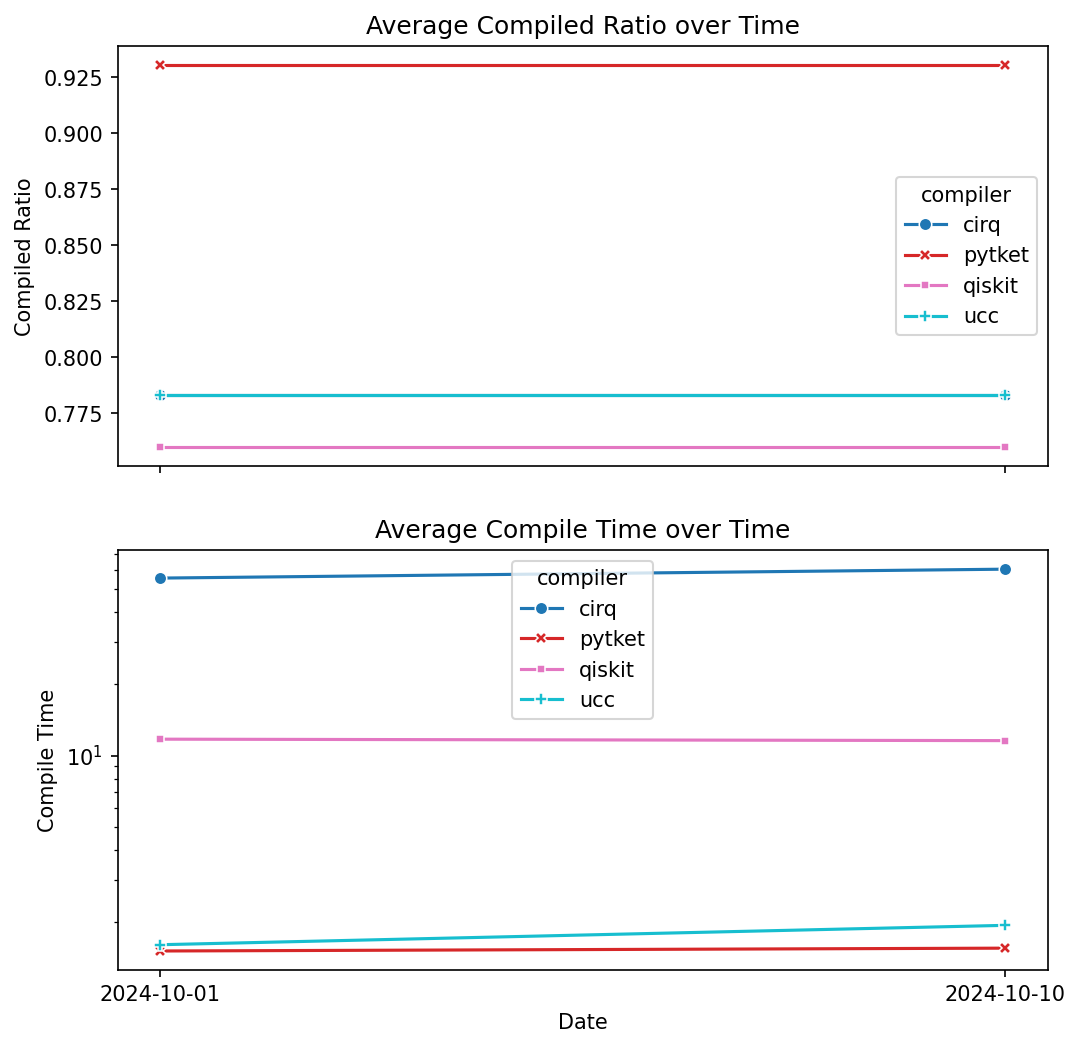

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set global DPI
plt.rcParams['figure.dpi'] = 150  # Adjust DPI as needed

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

unique_compilers = df_dates["compiler"].unique()
colormap = plt.get_cmap("tab10", len(unique_compilers))
color_map = {compiler: colormap(i) for i, compiler in enumerate(unique_compilers)}

# Plot avg_compiled_ratio
sns.lineplot(
    data=avg_compiled_ratio, 
    x="date", 
    y="compiled_ratio", 
    hue="compiler", 
    style="compiler", 
    markers=True, 
    dashes=False, 
    palette=color_map, 
    ax=ax[0]
)
ax[0].set_title("Average Compiled Ratio over Time")
ax[0].set_ylabel("Compiled Ratio")

# Plot avg_compile_time
sns.lineplot(
    data=avg_compile_time, 
    x="date", 
    y="compile_time", 
    hue="compiler", 
    style="compiler", 
    markers=True, 
    dashes=False, 
    palette=color_map, 
    ax=ax[1]
)
ax[1].set_title("Average Compile Time over Time")
ax[1].set_ylabel("Compile Time")
ax[1].set_xlabel("Date")
ax[1].set_yscale("log")
ax[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

#plt.tight_layout()
plt.show()


***A note on terminology***

There is some disagreement in the quantum computing community on the proper usage of the terms "transpilation" and "compilation." For instance, Qiskit refers to optimization of the Directed Acyclic Graph (DAG) of a circuit as "transpilation," whereas in qBraid, the 1:1 translation of one circuit representation into another (e.g. a Cirq circuit to a Qiskit circuit; OpenQASM 2 into PyTKET) without optimization is called "transpilation." Cirq on the other hand appears to use the terminology of "transformers" to refer to what Qiskit calls transpiler passes, which PyTKET appears to call CompilationUnits. 

This cornucopia of intersecting definitions does mean that this notebook necessarily mixes terminology. We feel relatively confident we've interpreted these objects and operations accurately across the SDKs we test, but if you find a mistake, please create an issue and let us know!

Within the UCC library, we refer to **transpilation** in the same sense as Qiskit: optimizing the DAG of a circuit in a fixed representation. We then use **compilation** to refer to the whole process, including translation from one circuit representation to another (e.g. OpenQASM 2 to Qiskit), plus DAG optimization (e.g. reducing the number of gates), but we also leave it open-ended to include additional stages in the future, like dynamic compilation based on mid-circuit measurements, quantum error mitigation, and even quantum error correction. [probably needs a diagram]